<a href="https://colab.research.google.com/github/rbgt/Bayesian_Data_Analysis/blob/main/%5BSwift%5DEM_algorithm_GaussianMixtureModel/Swift_EM_algorithm_for_GMM_3_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import Foundation
import Darwin
import Python
// This cell is here to display the plots in a Jupyter Notebook.
// Do not copy it into another environment.
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [ ]:
let shell = Python.import("subprocess").getoutput
let plt = Python.import("matplotlib.pyplot")

In [ ]:
shell("/swift/toolchain/usr/bin/swift --version")

Swift version 5.3-dev (LLVM db8896f3f345af2, Swift 61684f62a6132c0)
Target: x86_64-unknown-linux-gnu


In [ ]:
public struct Common {
    private static let pi = Double.pi
    
    /**
     Calculate `n!` for values of `n` that conform to the BinaryInteger
     protocol.  Returns `nil` if `n` is less than zero.
     */
    public static func factorial<T: BinaryInteger>(_ n: T) -> Int? {
        if n < 0 {
            return nil
        }
        return Int(tgamma(Double(n+1)))
    }

    /**
     Calculate `n!` for values of `n` that conform to the BinaryFloatingPoint
     protocol.  Uses the gamma function to "fill in" values of `n` that are
     not integers.  Returns `nil` if `n` is less than zero.
     */
    public static func factorial<T: BinaryFloatingPoint>(_ n: T) -> Double? {
        if n < 0 {
            return nil
        }
        return Double(tgamma(Double(n+1)))
    }

    /**
     Calculate n-choose-k for values of `n` and `k` that conform to the BinaryInteger
     protocol.
     */
    public static func choose<T: BinaryInteger>(n: T, k: T) -> Int {
        return Int(tgamma(Double(n + 1)))/Int(tgamma(Double(k + 1))*tgamma(Double(n - k + 1)))
    }

    /**
     Calculate n-choose-k for values of `n` that conform to the BinaryFloatingPoint
     protocol and values of `k` that conform to the BinaryInteger protocol.
     */
    public static func choose<N: BinaryFloatingPoint, K: BinaryInteger>(n: N, k: K) -> Double {
        return Double(tgamma(Double(n + 1)))/Double(tgamma(Double(k + 1))*tgamma(Double(Double(n) - Double(k) + 1)))
    }

    
    /**
     Calculates the mean of an array of values for types that satisfy the
     BinaryInteger protocol (e.g Int, Int32).
     
     - Parameters:
        - data: Array of values
     
     - Returns:
        The mean of the array of values or `nil` if the array was empty.
     */
    public static func mean<T: BinaryInteger>(_ data: [T]) -> Double? {
        if data.count == 0 {
            return nil
        }
        return Double(data.reduce(0, +))/Double(data.count)
    }

    /**
     Calculates the mean of an array of values for types that satisfy the
     BinaryFloatingPoint protocol (e.g Float, Double).
     
     - Parameters:
        - data: Array of values
     
     - Returns:
     The mean of the array of values or `nil` if the array was empty.
     */
    public static func mean<T : BinaryFloatingPoint>(_ data: [T]) -> Double? {
        if data.count == 0 {
            return nil
        }
        return Double(data.reduce(0, +))/Double(data.count)
    }

    
    /**
     Calculates the unbiased sample variance for an array for types that satisfy
     the BinaryFloatingPoint protocol (e.g Float, Double).
     
     - Parameters:
        - data:
        Sample of values.  Note that this should contain at least two values.
     
     - Returns:
        The unbiased sample variance or `nil` if `data` contains fewer than two
        values.
     */
    public static func variance<T: BinaryFloatingPoint>(_ data: [T]) -> Double? {
        if data.count < 2 {
            return nil
        }
        
        guard let m = mean(data) else {
            return nil // This shouldn't ever occur
        }
        var total = 0.0
        for i in 0..<data.count {
            total += pow(Double(data[i]) - m,2)
        }
        return total/Double(data.count-1)
    }
    
    /**
     Calculates the unbiased sample standard deviation for an array of values
     for types that satisfy the BinaryFloatingPoint protocol (e.g Float, Double).
     
     - Parameters:
        - data:
        Sample of values.  Note that this should contain at least two values.
     
     - Returns:
        The sample unbiased standard deviation or `nil` if `data` contains fewer
        than two values.
     */
    public static func sd<T: BinaryFloatingPoint>(_ data: [T]) -> Double? {
        guard let v = variance(data) else {
            return nil
        }
        return sqrt(v)
    }
    
    /**
     Calculates the unbiased sample standard deviation for an array of values
     for types that satisfy the BinaryInteger protocol (e.g Int, Int32).
     
     - Parameters:
        - data:
        Sample of values.  Note that this should contain at least two values.
     
     - Returns:
     The sample unbiased standard deviation or `nil` if `data` contains fewer
     than two values.
     */
    public static func sd<T: BinaryInteger>(_ data: [T]) -> Double? {
        guard let v = variance(data) else {
            return nil
        }
        return sqrt(v)
    }

    /**
     Calculates the population variance for an array of values for types that
     satisfy the BinaryFloatingPoint protocol (e.g Float, Double).
     
     - Parameters:
        - data:
        Values of population.  Note that this should contain at least one value.
     
     - Returns:
     The population variance or `nil` if `data` contains fewer than one value.
     */
    public static func pvariance<T: BinaryFloatingPoint>(_ data: [T]) -> Double? {
        if data.count < 1 {
            return nil
        }
        guard let m = mean(data) else {
            return nil // This shouldn't ever occur
        }
        var total = 0.0
        for i in 0..<data.count {
            total += pow(Double(data[i]) - m,2)
        }
        return total/Double(data.count)
    }

    /**
     Calculates the unbiased sample variance for an array of values for types
     that satisfy the BinaryInteger protocol (e.g Int, Int32).
     
     - Parameters:
        - data:
        Sample of values.  Note that this should contain at least two values.
     
     - Returns:
     The unbiased sample variance or `nil` if `data` contains fewer than two
     values.
     */
    public static func variance<T: BinaryInteger>(_ data: [T]) -> Double? {
        if data.count < 2 {
            return nil
        }
        
        guard let m = mean(data) else {
            return nil // This shouldn't ever occur
        }
        var total = 0.0
        for i in 0..<data.count {
            total += pow(Double(data[i]) - m,2)
        }
        return total/Double(data.count-1)
    }

    /**
     Calculates the population variance for an array of values for types that
     satisfy the BinaryInteger protocol (e.g Int, Int32).
     
     - Parameters:
        - data:
        Values of population.  Note that this should contain at least one value.
     
     - Returns:
     The population variance or `nil` if `data` contains fewer than one value.
     */
    public static func pvariance<T: BinaryInteger>(_ data: [T]) -> Double? {
        guard let m = mean(data) else {
            return nil
        }
        var total = 0.0
        for i in 0..<data.count {
            total += pow(Double(data[i]) - m,2)
        }
        return total/Double(data.count)
    }
    
    /**
     Calculates the median of an array of values for types that
     satisfy the BinaryFloatingPoint protocol (e.g Float, Double).
     
     - Parameters:
        - data:
        Values of population.  Note that this should contain at least one value.
     
     - Returns:
     The population variance or `nil` if `data` contains fewer than one value.
     */
    public static func median<T: BinaryFloatingPoint>(_ data: [T]) -> Double? {
        if data.isEmpty {
            return nil
        }
        let sorted_data = data.sorted()
        if data.count % 2 == 1 {
            return Double(sorted_data[Int(floor(Double(data.count)/2))])
        }
        else {
            return Double(sorted_data[data.count/2]+sorted_data[(data.count/2)-1])/2
        }
    }
    
    /**
     Calculates the median of an array of values for types that
     satisfy the BinaryInteger protocol (e.g Int, Int32).
     
     - Parameters:
        - data:
        Values of population.  Note that this should contain at least one value.
     
     - Returns:
     The population variance or `nil` if `data` contains fewer than one value.
     */
    public static func median<T: BinaryInteger>(_ data: [T]) -> Double? {
        if data.isEmpty {
            return nil
        }
        let sorted_data = data.sorted()
        if data.count % 2 == 1 {
            return Double(sorted_data[Int(floor(Double(data.count)/2))])
        }
        else {
            return Double(sorted_data[data.count/2]+sorted_data[(data.count/2)-1])/2
        }
    }

   
    public static func erfinv(_ y: Double) -> Double {
        let center = 0.7
        let a = [ 0.886226899, -1.645349621,  0.914624893, -0.140543331]
        let b = [-2.118377725,  1.442710462, -0.329097515,  0.012229801]
        let c = [-1.970840454, -1.624906493,  3.429567803,  1.641345311]
        let d = [ 3.543889200,  1.637067800]
        if abs(y) <= center {
            let z = pow(y,2)
            let num = (((a[3]*z + a[2])*z + a[1])*z) + a[0]
            let den = ((((b[3]*z + b[2])*z + b[1])*z + b[0])*z + 1.0)
            var x = y*num/den
            x = x - (erf(x) - y)/(2.0/sqrt(pi)*exp(-x*x))
            x = x - (erf(x) - y)/(2.0/sqrt(pi)*exp(-x*x))
            return x
        }

        else if abs(y) > center && abs(y) < 1.0 {
            let z = pow(-log((1.0-abs(y))/2),0.5)
            let num = ((c[3]*z + c[2])*z + c[1])*z + c[0]
            let den = (d[1]*z + d[0])*z + 1
            // should use the sign public static function instead of pow(pow(y,2),0.5)
            var x = y/pow(pow(y,2),0.5)*num/den
            x = x - (erf(x) - y)/(2.0/sqrt(pi)*exp(-x*x))
            x = x - (erf(x) - y)/(2.0/sqrt(pi)*exp(-x*x))
            return x
        }

        else if abs(y) == 1 {
            return y*Double(Int.max)
        }

        else {
            // this should throw an error instead
            return Double.nan
        }
    }

    public static func lsr(_ points: [[Double]]) -> [Double] {
        var total_x = 0.0
        var total_xy = 0.0
        var total_y = 0.0
        var total_x2 = 0.0
        for i in 0..<points.count {
            total_x += points[i][0]
            total_y += points[i][1]
            total_xy += points[i][0]*points[i][1]
            total_x2 += pow(points[i][0], 2)
        }
        let N = Double(points.count)
        let b = (N*total_xy - total_x*total_y)/(N*total_x2 - pow(total_x, 2))
        let a = (total_y - b*total_x)/N
        return [a, b]
    }

}

In [ ]:
public protocol ContinuousDistribution {
    func quantile(_ p: Double) -> Double
}

extension ContinuousDistribution {
    /**
     Single discrete random value using a user-provided random number generator
     
     - Parameters:
       - using: A random number generator
     
     - Returns:
     A random number from the distribution represented by the instance
     */
    public func random<T: RandomNumberGenerator>(using generator: inout T) -> Double {
        let x = Double.random(in: 0.0...1.0,
                              using: &generator)
        return quantile(x)
    }

    /**
     Single discrete random value using the system random number generator
     
     - Returns:
     A random number from the distribution represented by the instance
     */
    public func random() -> Double {
        var rng = SystemRandomNumberGenerator()
        return random(using: &rng)
    }
    
    
    /**
     Array of discrete random values
     - Parameter n: number of values to produce
     - Complexity: O(n)
     */
    public func random(_ n: Int) -> [Double] {
        var results: [Double] = []
        for _ in 0..<n {
            results.append(random())
        }
        return results
    }

}

/**
 Protocol for discrete distributions.
 
 Defines the `quantile()` method that must be implemented.
 */
public protocol DiscreteDistribution {
    func quantile(_ p: Double) -> Int
}

extension DiscreteDistribution {
    /**
     Single discrete random value using a user-provided random number generator
     
     - Parameters:
       - using: A random number generator
     
     - Returns:
     A random number from the distribution represented by the instance
     */
    public func random<T: RandomNumberGenerator>(using generator: inout T) -> Int {
        let x = Double.random(in: 0.0...1.0,
                              using: &generator)
        return quantile(x)
    }
    
    /**
     Single discrete random value using the system random number generator
     
     - Returns:
     A random number from the distribution represented by the instance
     */
    public func random() -> Int {
        var rng = SystemRandomNumberGenerator()
        return random(using: &rng)
    }
    
    /**
     Array of discrete random values
     - Parameter n: number of values to produce
     - Complexity: O(n)
     */
    public func random(_ n: Int) -> [Int] {
        var results: [Int] = []
        for _ in 0..<n {
            results.append(random())
        }
        return results
    }

}

In [ ]:
public class Bernoulli: DiscreteDistribution {
    var p: Double
    
    public init(p: Double) {
        self.p = p
    }
    
    public convenience init?<T: BinaryInteger>(data: [T]) {
        guard let m = Common.mean(data) else {
            return nil
        }
        self.init(p: m)
    }
    
    public func pmf(_ k: Int) -> Double {
        if k == 1 {
            return self.p
        }
        if k == 0 {
            return 1 - self.p
        }
        return -1
    }
    
    public func cdf(_ k: Int) -> Double {
        if k < 0 {
            return 0
        }

        if k < 1 {
            return 1 - self.p
        }
        if k >= 1 {
            return 1
        }
        return -1
    }
    
    public func quantile(_ p: Double) -> Int {
        if p < 0 {
            return -1
        }
        else if p < 1 - self.p {
            return 0
        }
        else if p <= 1 {
            return 1
        }
        return -1
    }
}

In [ ]:
public class Normal: ContinuousDistribution {
    // mean and variance
    var m: Double
    var v: Double

    public init(m: Double, v: Double) {
        self.m = m
        self.v = v
    }
    
    public convenience init(mean: Double, sd: Double) {
        // This contructor takes the mean and standard deviation, which is the more
        // common parameterisation of a normal distribution.
        let variance = pow(sd, 2)
        self.init(m: mean, v: variance)
    }

    public convenience init?(data: [Double]) {
        // this calculates the mean twice, since variance()
        // uses the mean and calls mean()
        guard let v = Common.variance(data) else {
            return nil
        }
        guard let m = Common.mean(data) else {
            return nil // This shouldn't ever occur
        }
        self.init(m: m, v: v)
    }

    public func pdf(_ x: Double) -> Double {
        let pi = Common.pi
        return (1/pow(self.v * 2 * pi,0.5))*exp(-pow(x-self.m,2)/(2*self.v))
    }

    public func cdf(_ x: Double) -> Double {
        return (1 + erf((x-self.m)/pow(2*self.v,0.5)))/2
    }

    public func quantile(_ p: Double) -> Double {
        return self.m + pow(self.v*2,0.5)*Common.erfinv(2*p - 1)
    }
}

public class Uniform: ContinuousDistribution {
    // a and b are endpoints, that is
    // values will be distributed uniformly between points a and b
    var a: Double
    var b: Double

    public init(a: Double, b: Double) {
        self.a = a
        self.b = b
    }

    public func pdf(_ x: Double) -> Double {
        if x>a && x<b {
            return 1/(b-a)
        }
        return 0
    }

    public func cdf(_ x: Double) -> Double {
        if x<a {
            return 0
        }
        else if x<b {
            return (x-a)/(b-a)
        }
        else if x>=b {
            return 1
        }
        return 0
    }

    public func quantile(_ p: Double) -> Double {
        if p>=0 && p<=1{
            return p*(b-a)+a
        }
        return Double.nan
    }
}

In [ ]:
let array_range:Array = Array(stride(from: -25.0, to: 25.0 , by: 0.01))
let generative_m_ = [Normal(mean:-2.0 , sd: 5.0), 
                     Normal(mean:5.0 , sd: 2),
                     Normal(mean:10.0 , sd: 3)]

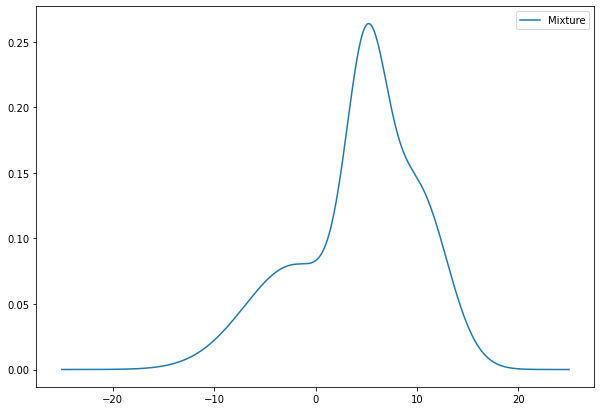

None


In [ ]:
plt.figure(figsize:[10,7])
plt.plot(array_range, zip(zip(array_range.map{generative_m_[0].pdf($0)},array_range.map{generative_m_[1].pdf($0)}).map(+), array_range.map{generative_m_[2].pdf($0)}).map(+), label:"Mixture")
plt.legend()
plt.show()

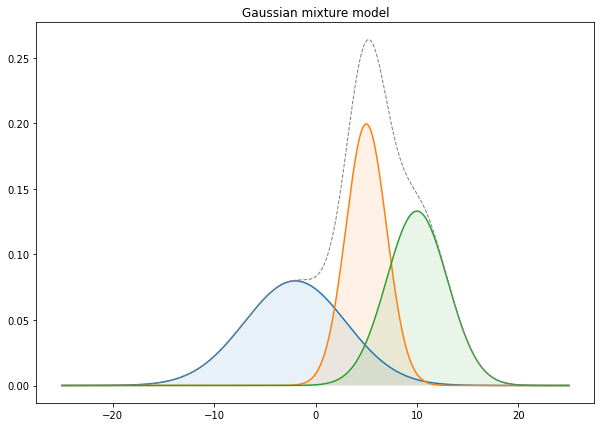

None


In [ ]:
plt.figure(figsize:[10,7])
plt.plot(array_range,array_range.map{generative_m_[0].pdf($0)})
plt.plot(array_range,array_range.map{generative_m_[1].pdf($0)})
plt.plot(array_range,array_range.map{generative_m_[2].pdf($0)})
plt.plot(array_range, zip(zip(array_range.map{generative_m_[0].pdf($0)},array_range.map{generative_m_[1].pdf($0)}).map(+), array_range.map{generative_m_[2].pdf($0)}).map(+), ls:"--",lw:"1",color:"grey")
plt.fill_betweenx(array_range.map{generative_m_[0].pdf($0)},array_range,alpha:0.1)
plt.fill_betweenx(array_range.map{generative_m_[1].pdf($0)},array_range,alpha:0.1)
plt.fill_betweenx(array_range.map{generative_m_[2].pdf($0)},array_range,alpha:0.1)
plt.title("Gaussian mixture model")
plt.show()

In [ ]:
// Draw random samples from 3 Gaussians
let range = (1...100)
var z_i = Array<Int>()
z_i = range.map{_ in 
                [0,1,2].randomElement()!}
var x_i = (z_i.map {generative_m_[$0].random()})

// var x_i = zip(zip(array_range.map{generative_m_[0].pdf($0)},array_range.map{generative_m_[1].pdf($0)}).map(+), array_range.map{generative_m_[2].pdf($0)}).map(+)
// print(x_i.enumerated().compactMap { index, element in index % 2 == 0 ? nil : element })
// print(x_i.enumerated().compactMap { index, element in index % 2 == 0 ? nil : element }.count)
// x_i = x_i.enumerated().compactMap { index, element in index % 2 == 0 ? nil : element }

In [ ]:
extension Sequence where Element: AdditiveArithmetic {
    /// Returns the total sum of all elements in the sequence
    func sum() -> Element { reduce(.zero, +) }
}
extension Collection where Element: BinaryInteger {
    /// Returns the average of all elements in the array
    func average() -> Element { isEmpty ? .zero : sum() / Element(count) }
    /// Returns the average of all elements in the array as Floating Point type
    func average<T: FloatingPoint>() -> T { isEmpty ? .zero : T(sum()) / T(count) }
}
extension Collection where Element: BinaryFloatingPoint {
    /// Returns the average of all elements in the array
    func average() -> Element { isEmpty ? .zero : Element(sum()) / Element(count) }
}

public func testNearZero(_ a: Double, tolerance: Double = 1e-3) -> Bool {
    assert(abs(a) < tolerance, "Near zero: \(a)")
    return true
}

public func testNearZero_(_ a: Double, tolerance: Double = 1e-3) -> Bool {
    if abs(a) < tolerance {return true}
    else {return false}
}

In [ ]:
public struct EM {
    var k: Int
    var mu: [Double] = []
    var std: [Double]
    var w_ij = [[Double]]()
    var elements: [Double] = []
    var phi: [Double] = []
    var tot_dims: [Double] = []
    var sum_ax1: [Double] = []

    init(_ k: Int){
        self.k = k
        self.std = [Double](repeating:1, count: self.k)
        self.phi = [Double](repeating:1, count: self.k).map{$0 / Double(self.k)}
        self.mu = [Double](repeating:0, count: self.k).map{$0 / Double(self.k)}
    }
    public mutating func expectation_step(_ x:[Double]) {
        self.elements = [Double](repeating:0, count: x.count)
        self.tot_dims = self.elements
        for z_i in 0..<self.k {
            self.w_ij.append(self.elements)
            self.w_ij[z_i] = x.map{Normal(mean: self.mu[z_i], sd:self.std[z_i]).pdf($0)}
            self.w_ij[z_i] = self.w_ij[z_i].map{ $0 * self.phi[z_i]}
        }
        //Calcul de somme sur l'axe 0
        for row in 0..<self.elements.count {
            for column in 0..<self.w_ij.count {
                self.tot_dims[row] = self.w_ij[column][row] + self.tot_dims[row]
            }
        }
        // w_ij /= w_ij.sum(0)
        for column in 0..<self.w_ij.count {
            for row in 0..<self.elements.count {
                self.w_ij[column][row] = self.w_ij[column][row] / self.tot_dims[row]
            }
        }
    }
    public mutating func maximization_step(_ x:[Double]) {
        self.sum_ax1 = self.elements
        //Calcul de la moyenne des w_ij sur l'axe 1
        for i in 0..<self.k {
            self.phi[i] = self.w_ij[i].average()
            //Maximization of mu : (self.w_ij * x).sum(1) / self.w_ij.sum(1)
            self.mu[i] = ((0..<x.count).map{self.w_ij[i][$0] * x[$0]}).reduce(0,+)
            self.mu[i] = self.mu[i] / self.w_ij[i].sum()
            //Maximization of std : self.std = ((self.w_ij * (x - self.mu[:, None])**2).sum(1) / self.w_ij.sum(1))**0.5
            self.sum_ax1 = (0..<x.count).map{self.w_ij[i][$0] * pow((x[$0] - self.mu[i]),2)}
            self.std[i] = self.sum_ax1.reduce(0,+) / self.w_ij[i].sum()
            self.std[i] = pow(self.std[i], 0.5)
        }
    }
    public mutating func fit(_ x:[Double]) {
        self.mu = Uniform(a: x.min()!, b:x.max()!).random(self.k)
        //self.w_ij = np.zeros((self.k,x.shape[0]))
        self.elements = [Double](repeating:0, count: x.count)
        for i in 0..<self.k {
            self.w_ij.append(self.elements)
        }
        //last_mu = np.ones(self.k) * np.inf
        var last_mu:[Double] = [Double](repeating:Double.infinity, count: self.k)
        //Difference calculation : self.mu - last_mu
        var diff: [Double] = [Double](repeating:0, count: self.k)
        var diff_bools: [Bool] = [Bool](repeating: false, count:self.k)
        for i in 0..<self.k {
            diff[i] = last_mu[i] - self.mu[i]
            if testNearZero_(diff[i]) { diff_bools[i] = true }
            else { diff_bools[i] = false }
        }

        while !diff_bools.allSatisfy({$0 == true}) {
            last_mu = self.mu
            self.expectation_step(x)
            self.maximization_step(x)
            for i in 0..<self.k {
                diff[i] = last_mu[i] - self.mu[i]
                if testNearZero_(diff[i]) { diff_bools[i] = true }
                else { diff_bools[i] = false }
            }
        }

    }


}

In [ ]:
var obj = EM(3)

In [ ]:
obj.fit(x_i)

In [ ]:
obj.mu.count

3


In [ ]:
print(obj.mu, obj.std)

[-1.0447968798073657, 10.93624890902223, 5.491394771705267] [4.407151970008856, 2.4552947991485032, 1.523898990420272]


In [ ]:
let fitted_m = [Normal(mean:obj.mu[0] , sd: obj.std[0]), 
                Normal(mean:obj.mu[1] , sd: obj.std[1]), 
                Normal(mean:obj.mu[2] , sd: obj.std[2])]

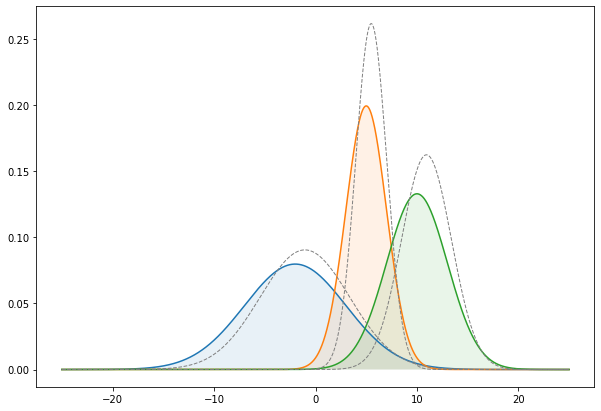

None


In [ ]:
plt.figure(figsize:[10,7])
plt.plot(array_range,array_range.map{generative_m_[0].pdf($0)})
plt.plot(array_range,array_range.map{generative_m_[1].pdf($0)})
plt.plot(array_range,array_range.map{generative_m_[2].pdf($0)})
plt.plot(array_range,array_range.map{fitted_m[0].pdf($0)}, lw:1,ls:"--", c:"grey")
plt.plot(array_range,array_range.map{fitted_m[1].pdf($0)}, lw:1,ls:"--", c:"grey")
plt.plot(array_range,array_range.map{fitted_m[2].pdf($0)}, lw:1,ls:"--", c:"grey")
plt.fill_betweenx(array_range.map{generative_m_[0].pdf($0)},array_range,alpha:0.1)
plt.fill_betweenx(array_range.map{generative_m_[1].pdf($0)},array_range,alpha:0.1)
plt.fill_betweenx(array_range.map{generative_m_[2].pdf($0)},array_range,alpha:0.1)
plt.show()